# Part 2 : Convolutional Neural Networks

In [1]:
from __future__ import print_function

import os
import random
import numpy as np
import tensorflow as tf
from six.moves import range
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt


#configuration for gpu usage
conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.4
conf.gpu_options.allow_growth = True
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 28, 28) (50000,)
Test set (10000, 28, 28) (10000,)


==== For training ====
[7 7 1 6 0 6 4 3 1 3]


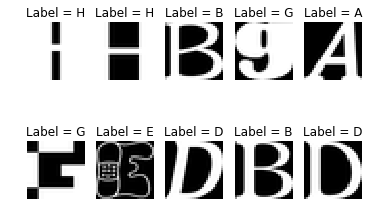

In [3]:
Row = 2
Column = 5
ListOfLabel = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

print("==== For training ====")
rand = random.randint(0, 29989)
images = train_dataset[rand:rand+10]
labels = train_labels[rand:rand+10]
print(labels)
for i, image in enumerate(images):
    plt.subplot(Row, Column, i+1)
    plt.title('Label = {}'.format(ListOfLabel[labels[i]]))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
image_size = 28
num_labels = 10

#Reshape training and testing image
train_X = train_dataset.reshape(-1, 28, 28, 1)
test_X = test_dataset.reshape(-1, 28, 28, 1)
train_y = (np.arange(10) == train_labels[:,None])
test_y = (np.arange(10) == test_labels[:,None])
print(train_X.shape, test_X.shape)
print(train_y.shape, test_y.shape)


(50000, 28, 28, 1) (10000, 28, 28, 1)
(50000, 10) (10000, 10)


In [5]:
training_iters = 50
learning_rate = 0.001 
batch_size = 128

# MNIST data input (img shape: 28*28)
n_input = 28

# MNIST total classes (0-9 digits)
n_classes = 10

In [6]:
#both placeholders are of type float
x = tf.placeholder("float", [None, 28, 28, 1])
y = tf.placeholder("float", [None, n_classes])

In [7]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [8]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W4', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer())
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer())
}

Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
def conv_net(x, weights, biases):  

    # call the conv2d function defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = tf.nn.relu(conv1)
    # choose the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)


    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = tf.nn.relu(conv2)
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv3 = tf.nn.relu(conv3)
    conv3 = maxpool2d(conv3, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # Multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [10]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Check whether the index of the maximum value of the predicted image is equal to the actual labelled image
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# calculate accuracy across all the given images
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
# Initializing the variables
init = tf.global_variables_initializer()

In [12]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]
            # Run optimization op.
            opt = sess.run(optimizer, feed_dict={x:batch_x, y:batch_y})
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x:batch_x,y:batch_y})

        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))

        # Calculate accuracy for all test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x:test_X,y :test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.425042, Training Accuracy= 0.88281
Optimization Finished!
Testing Accuracy: 0.93560
Iter 1, Loss= 0.349301, Training Accuracy= 0.89844
Optimization Finished!
Testing Accuracy: 0.94720
Iter 2, Loss= 0.312635, Training Accuracy= 0.90625
Optimization Finished!
Testing Accuracy: 0.95120
Iter 3, Loss= 0.266057, Training Accuracy= 0.91406
Optimization Finished!
Testing Accuracy: 0.95200
Iter 4, Loss= 0.230782, Training Accuracy= 0.93750
Optimization Finished!
Testing Accuracy: 0.95150
Iter 5, Loss= 0.198503, Training Accuracy= 0.92188
Optimization Finished!
Testing Accuracy: 0.94790
Iter 6, Loss= 0.162173, Training Accuracy= 0.95312
Optimization Finished!
Testing Accuracy: 0.94680
Iter 7, Loss= 0.120028, Training Accuracy= 0.95312
Optimization Finished!
Testing Accuracy: 0.94250
Iter 8, Loss= 0.100624, Training Accuracy= 0.96875
Optimization Finished!
Testing Accuracy: 0.94600
Iter 9, Loss= 0.087937, Training Accuracy= 0.98438
Optimization Finished!
Testing Accuracy: 0.94680


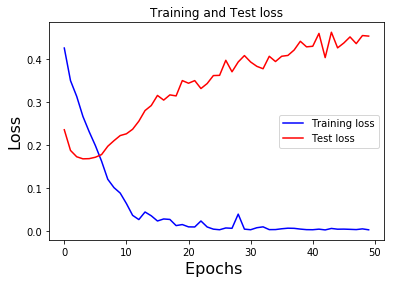

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

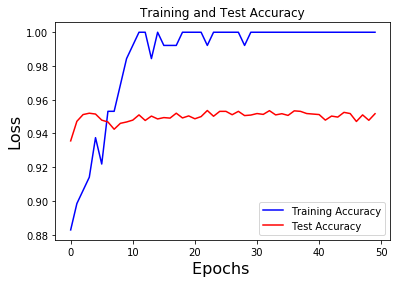

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()